In [9]:
import numpy as np
from pprint import pprint
import sys, os
import pickle as pkl
from time import time
import matplotlib.pyplot as plt

import matplotlib
font = {'family' : 'sans-serif',
         'sans-serif': 'Arial',
         'style': 'normal',
         'weight': 'normal',
         'size'   : 18}
matplotlib.rc('font', **font)

from os.path import expanduser
home = expanduser("~")
model_home = os.path.join(home, 'src/model/ca3_biophysical/')
sys.path.append(os.path.join(home, 'src/model/ca3_biophysical/utils'))
sys.path.append(os.path.join(home, 'src/model/ca3_biophysical/cells'))
from SetupConnections import *
from NeuronCircuit import Circuit
from analysis_utils import baks
from neuron import h



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:

delay = 500.

params_path = os.path.join(model_home, 'params')
ar = Arena(os.path.join(params_path, 'arenaparams.yaml'))
ar.generate_population_firing_rates()
#ar.generate_cue_firing_rates('LEC', 1.0)

ar.generate_spike_times('MF', dt=0.05, delay=delay)
ar.generate_spike_times('MEC', dt=0.05, delay=delay)
ar.generate_spike_times('LEC', dt=0.05, delay=delay, cued=False)
ar.generate_spike_times('Background', dt=0.05, delay=delay)


In [11]:
arena_size = ar.params['Arena']['arena size']
bin_size   = ar.params['Arena']['bin size']
mouse_speed = ar.params['Arena']['mouse speed']
nlaps       = ar.params['Arena']['lap information']['nlaps']

time_for_single_lap = arena_size / mouse_speed * 1000.
print(time_for_single_lap, nlaps)

6666.666666666667 20


frac place 0.8


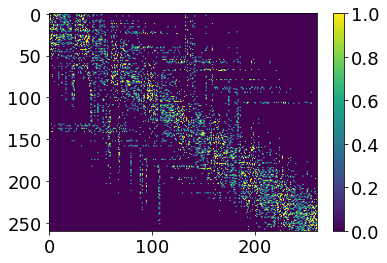

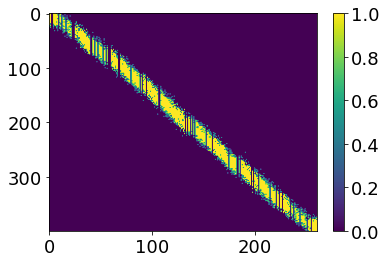

In [12]:
place_information = {'place ids': [0], 'place fracs': [0.80]}

diagram = WiringDiagram('params/circuitparams.yaml', place_information)
diagram.generate_internal_connectivity()

external_kwargs = {}
external_kwargs['place information'] = diagram.place_information
external_kwargs['external place ids'] = [100, 101]
external_kwargs['cue information'] = diagram.place_information
external_kwargs['external cue ids'] = [102]

diagram.generate_external_connectivity(ar.cell_information, **external_kwargs)
diagram.generate_septal_connectivity()

plt.figure()
plt.imshow(diagram.internal_adj_matrices[0][0], aspect='auto')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(diagram.external_adj_matrices[100][0], aspect='auto')
plt.colorbar()
plt.show()


In [13]:
def pull_spike_times(population2info_dict):
    spike_times = []
    gids = np.sort(list(population2info_dict.keys()))
    for gid in gids:
        spike_times.append(population2info_dict[gid]['spike times'])
    return spike_times

mf_spike_times  = pull_spike_times(ar.cell_information['MF']['cell info'])
mec_spike_times = pull_spike_times(ar.cell_information['MEC']['cell info'])
lec_spike_times = pull_spike_times(ar.cell_information['LEC']['cell info'])
bk_spike_times  = pull_spike_times(ar.cell_information['Background']['cell info'])

In [15]:
#  'circuitparams_ripple_72522.yaml'
circuit = Circuit(os.path.join(params_path, 'circuitparams_ripple.yaml'), 
                  diagram.pop2id, diagram.external_pop2id, params_path=params_path)
circuit.build_cells()
circuit.build_internal_netcons(diagram.internal_adj_matrices)
circuit.build_external_netcons(100, diagram.external_adj_matrices[100], mf_spike_times)
circuit.build_external_netcons(101, diagram.external_adj_matrices[101], mec_spike_times)
circuit.build_external_netcons(102, diagram.external_adj_matrices[102], lec_spike_times)
circuit.build_external_netcons(103, diagram.external_adj_matrices[103], bk_spike_times)
#circuit.record_lfp([0,1])
#circuit.build_septal_netcons(diagram.septal_adj_matrices)

In [16]:
#model_filepath = 'models/72722-cue-ee-ie-nlaps-15-dt-zerodot1-scale-2-v1.npz'
model_filepath = 'params/0801-cue-ee-ei-nlaps-20-dt-zerodot1-scale-2-v1.npz'

#79-V1 is best so far


f = np.load(model_filepath, allow_pickle=True)
fkeys = f.keys()
for fk in fkeys:
    try: fk = int(fk)
    except: 
        print('fail:',fk)
        continue

    population_info = circuit.neurons[fk]
    weights = f[str(fk)]
    counter = 0
    for cell_gid in population_info.keys():
        cell_info = population_info[cell_gid]
        for (presynaptic_gid, nc, _) in cell_info.internal_netcons:
            for netcon in nc:
                base_weight  = weights[counter]
                added_weight = weights[counter + 1]
                total_weight = base_weight + added_weight
                netcon.weight[0] = total_weight
                counter += 2
        for external_id in cell_info.external_netcons.keys():
            external_cell_info = cell_info.external_netcons[external_id]
            for (idx,(presynaptic_gid, nc, compartment)) in enumerate(external_cell_info):
                for netcon in nc:
                    base_weight  = weights[counter]
                    added_weight = weights[counter + 1]
                    total_weight = base_weight + added_weight
                    netcon.weight[0] = total_weight
                    counter += 2 
    print(len(weights), counter)

241600 241600
59040 59040


5200
place median 0.0007
nonplace median 0.0007
place mean 0.0006999999999999999
nonplace mean 0.0006999999999999998
22.440334700657484 1.5821942782778043e-106
mwu 2035200.0 1.0


/tmp/ipykernel_399812/2236733975.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t, p = ttest_ind(pvbc_to_place_weights, pvbc_to_notplace_weights)


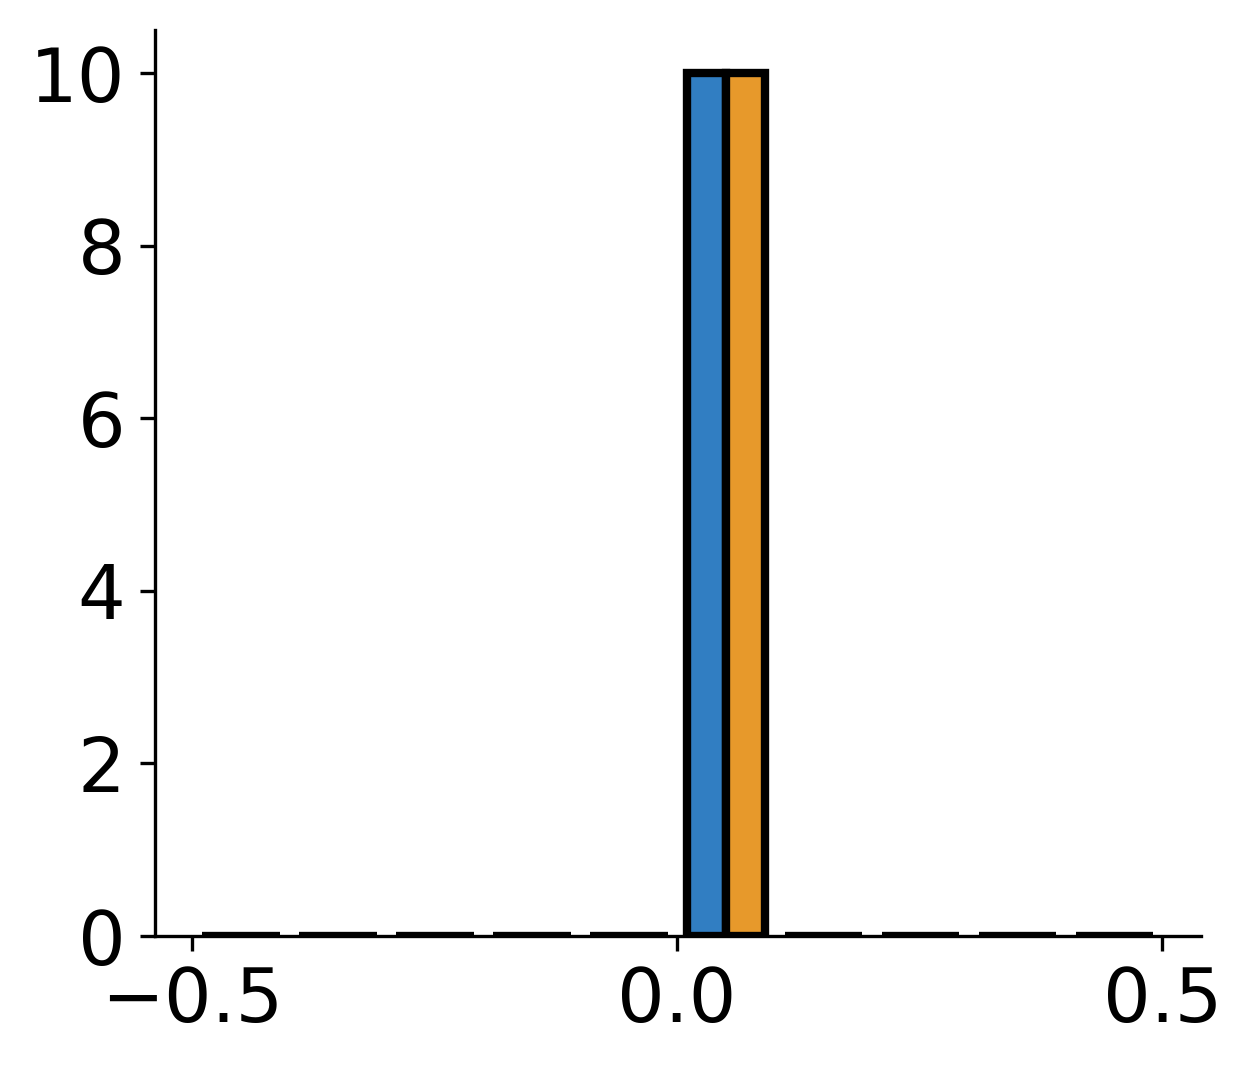

In [17]:
place_cells = diagram.place_information[0]['place']
non_place_cells = diagram.place_information[0]['not place']
scale = 2

pvbc_to_place_weights = []
for pgid in place_cells:
    cell_info = circuit.neurons[0][pgid].internal_netcons
    for (presynaptic_gid, nc, _) in cell_info:
        if presynaptic_gid >= 130*scale and presynaptic_gid < 145*scale:
            weight = nc[0].weight[0] #+ nc[0].weight[1]
            pvbc_to_place_weights.append(weight)

pvbc_to_notplace_weights = []
for pgid in non_place_cells:
    cell_info = circuit.neurons[0][pgid].internal_netcons
    for (presynaptic_gid, nc, _) in cell_info:
        if presynaptic_gid >= 130*scale and presynaptic_gid < 145*scale:
            weight = nc[0].weight[0] #+ nc[0].weight[1]
            pvbc_to_notplace_weights.append(weight)      
        

print(len(pvbc_to_place_weights) + len(pvbc_to_notplace_weights))
        
        
fig = plt.figure(dpi=300, figsize=(4.5, 4.0))
ax = fig.gca()
plt.hist([pvbc_to_place_weights, pvbc_to_notplace_weights], color=[(49/255.,126/255.,194/255.), (231/255.,135/225.,43/255.)], 
         density=True, edgecolor='k', linewidth=2.0)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

    
print('place median', np.median(pvbc_to_place_weights))
print('nonplace median', np.median(pvbc_to_notplace_weights))

 
print('place mean', np.mean(pvbc_to_place_weights))
print('nonplace mean', np.mean(pvbc_to_notplace_weights))

from scipy.stats import ttest_ind, mannwhitneyu
t, p = ttest_ind(pvbc_to_place_weights, pvbc_to_notplace_weights)
print(t, p)

u, pmw = mannwhitneyu(pvbc_to_place_weights, pvbc_to_notplace_weights, alternative='less')
print('mwu', u, pmw)


In [18]:
## run patch clamp recording 

basket_cells = circuit.neurons[1]
pyr_cells    = circuit.neurons[0]

place_ids = diagram.place_information[0]['place']
cue_ids   = diagram.place_information[0]['not place']

place_cells = [pyr_cells[pid] for pid in place_ids]
cue_cells   = [pyr_cells[cid] for cid in cue_ids]

def run_patch_clamp_expr(bs, pyr, holding_v=-70, dt=0.025, tstop=100., return_truncated=True):
    
    
    t_vec = h.Vector()
    t_vec.record(h._ref_t)
    h.dt   = dt
    h.tstop = tstop
    
    bs_v_vec  = h.Vector()
    pyr_v_vec = h.Vector()
    pyr_i_vec = h.Vector()
    
    gaba_a_pyr = pyr.synGroups['GABAA']['soma'][1][0]

    
    bs_v_vec.record(bs.soma(0.5)._ref_v)
    pyr_v_vec.record(pyr.soma(0.5)._ref_v)
    pyr_i_vec.record(gaba_a_pyr._ref_i)
    
    
    vclamp = h.VClamp(pyr.soma(0.5))
    vclamp.amp[0] = holding_v
    vclamp.dur[0] = 200.
    
    
    iclamp = h.IClamp(bs.soma(0.5))
    iclamp.delay = 25.
    iclamp.dur = 1.
    iclamp.amp = 2.0   
    
    h.celsius = 37.
    h.finitialize(-65)
    h.fadvance()
    h.continuerun(h.tstop)
    
    if return_truncated:
        return max(list(pyr_i_vec))
    
    return list(t_vec), list(bs_v_vec), list(pyr_i_vec)



def patch_clamp(holding_v):
    dt = 0.5
    place_ipsp_lst = []
    count = 0
    for i in range(len(place_ids)):
        cell_info = place_cells[i].internal_netcons
        for (pre_id, _, _) in cell_info:
            if pre_id >= 260: #130:
                basket_id = pre_id - 260
                #dontuncomment tplace, bsplace, pyrplace = run_patch_clamp_expr(basket_cells[basket_id], place_cells[i], holding_v = -65, dt=0.25, tstop=150., return_truncated=False)
                place_ipsp = run_patch_clamp_expr(basket_cells[basket_id], place_cells[i], holding_v = holding_v, dt=dt, tstop=50., return_truncated=True)
                place_ipsp_lst.append(place_ipsp)


    print('holding v completed place cell pairs')
    cue_ipsp_lst = []
    for i in range(len(cue_ids)):
        cell_info = cue_cells[i].internal_netcons
        for (pre_id, _, _) in cell_info:
            if pre_id >= 260: #130:
                basket_id = pre_id - 260
                #dont uncomment tcue, bscue, pyrcue = run_patch_clamp_expr(basket_cells[basket_id], cue_cells[i], holding_v = -65, dt=0.25, tstop=150., return_truncated=False)
                cue_ipsp = run_patch_clamp_expr(basket_cells[basket_id], cue_cells[i], holding_v = holding_v, dt=dt, tstop=50., return_truncated=True)
                cue_ipsp_lst.append(cue_ipsp)
                count += 1
                
    return np.asarray(place_ipsp_lst), np.asarray(cue_ipsp_lst)
                
holding_vs = [-65, -60, -55, -50, -45]
place_patch_clamp_data = {v:[] for v in holding_vs}
cue_patch_clamp_data = {v:[] for v in holding_vs}

#color=[(49/255.,126/255.,194/255.), (231/255.,135/225.,43/255.)

for v in holding_vs:
    print('starting v...')
    tic = time()
    place_data, cue_data = patch_clamp(v)
    place_patch_clamp_data[v] = place_data
    cue_patch_clamp_data[v]   = cue_data
    elapsed = time() - tic
    print('v: %d took %0.3f seconds' % (v, elapsed))



starting v...
holding v completed place cell pairs
v: -65 took 2968.439 seconds
starting v...
holding v completed place cell pairs
v: -60 took 2893.543 seconds
starting v...
holding v completed place cell pairs
v: -55 took 2889.196 seconds
starting v...
holding v completed place cell pairs
v: -50 took 2875.848 seconds
starting v...
holding v completed place cell pairs
v: -45 took 2883.088 seconds


In [12]:


with open('place_clamp_exprs-82222.pickle', 'wb') as handle:
    pkl.dump(place_patch_clamp_data, handle)
    
with open('cue_clamp_exprs-82222.pickle', 'wb') as handle:
    pkl.dump(cue_patch_clamp_data, handle)

In [5]:
f = open('place_clamp_exprs.pickle', 'rb')
file = pkl.load(f)
holding_vs = list(file.keys())
place_patch_clamp_data = {v:[] for v in holding_vs}
for v in holding_vs:
    place_patch_clamp_data[v] = file[v]
f.close()


f = open('cue_clamp_exprs.pickle', 'rb')
file = pkl.load(f)
cue_patch_clamp_data = {v:[] for v in holding_vs}
for v in holding_vs:
    cue_patch_clamp_data[v] = file[v]
f.close()


4240 960
-65 place 0.31490503368287387 0.18609392005781905 4240
-65 cue 0.35606070451255983 0.07130504660856543 960
4240 960
-60 place 0.47233382683363834 0.27912686821651117 4240
-60 cue 0.5340642428221528 0.10695220086949508 960
4240 960
-55 place 0.6297626129975016 0.3721598123245345 4240
-55 cue 0.7120677731336726 0.1425993536138195 960
4240 960
-50 place 0.7871913876588982 0.4651927497954343 4240
-50 cue 0.8900712912315406 0.1782465042969294 960
4240 960
-45 place 0.9446201459925788 0.5582256778733087 4240
-45 cue 1.068074795971746 0.21389364932359203 960


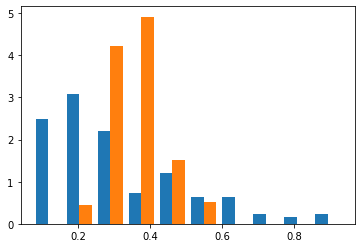

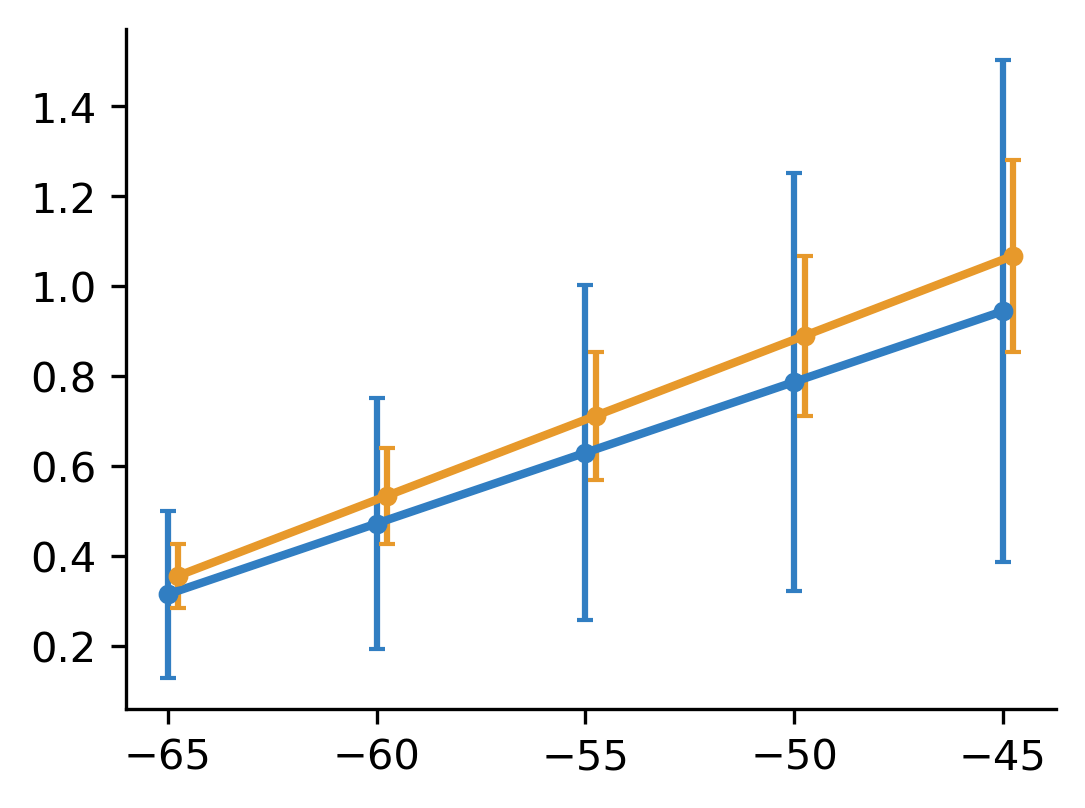

In [18]:
pmeans, pstds = [], []
cmeans, cstds = [], []

for v in holding_vs:
    place_data = place_patch_clamp_data[v]
    cue_data   = cue_patch_clamp_data[v]
    print(len(place_data), len(cue_data))
    
    if v == -65:
        plt.figure()
        plt.hist([place_data, cue_data], density=True)
    
    pmean, pstd = place_data.mean(), place_data.std()
    print(v,'place', pmean, pstd, len(place_data))
    pmeans.append(pmean)
    pstds.append(pstd)
    
    cmean, cstd = cue_data.mean(), cue_data.std()
    print(v,'cue', cmean, cstd, len(cue_data))
    cmeans.append(cmean)
    cstds.append(cstd)

pmeans = np.asarray(pmeans)
pstds  = np.asarray(pstds)

cmeans = np.asarray(cmeans)
cstds  = np.asarray(cstds)

holding_vs_ = np.asarray(holding_vs)
   
#color=[(49/255.,126/255.,194/255.), (231/255.,135/225.,43/255.)

fig = plt.figure(dpi=300, figsize=(4,3))
ax  = fig.gca()

ax.plot(holding_vs, pmeans, c=(49/255.,126/255.,194/255.), marker='.', markersize=7.5, linewidth=2)
ax.errorbar(holding_vs, pmeans, yerr=pstds, color=(49/255.,126/255.,194/255.), capsize=2)
ax.plot(holding_vs_+0.25, cmeans, c=(231/255.,135/225.,43/255.), marker='.', markersize=7.5, linewidth=2)
ax.errorbar(holding_vs_+0.25, cmeans, yerr=cstds, color=(231/255.,135/225.,43/255.), capsize=2)

for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)


In [14]:
from scipy.stats import ttest_ind, mannwhitneyu

for v in holding_vs:
    U, p = mannwhitneyu(place_patch_clamp_data[v], cue_patch_clamp_data[v], alternative='less')
    print(v,U,p)

-65 1351881.0 8.234173219259381e-60
-60 1351881.0 8.234502827632171e-60
-55 1351881.0 8.234524577948079e-60
-50 1351881.0 8.234568825546018e-60
-45 1351881.0 8.234592303006239e-60


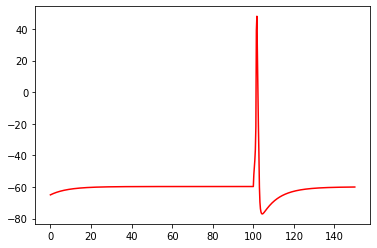

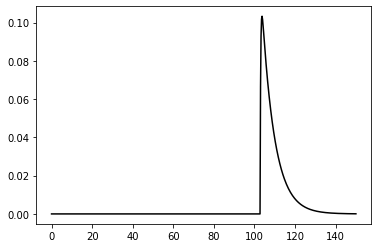

In [82]:
plt.figure()
plt.plot(tplace, bsplace, color='r')
plt.title('basket')
plt.show()

plt.figure()
plt.plot(tplace, pyrplace, color='k')
plt.show()

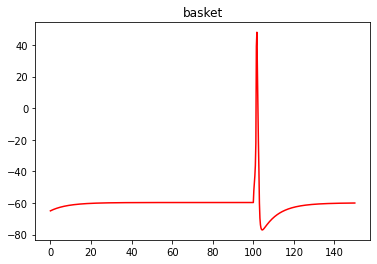

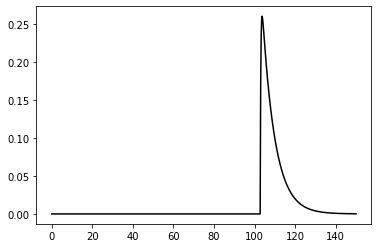

In [83]:
plt.figure()
plt.plot(tcue, bscue, color='r')
plt.title('basket')
plt.show()

plt.figure()
plt.plot(tcue, pyrcue, color='k')
plt.show()

In [256]:
import time

h.load_file("stdrun.hoc")

def get_population_voltages(c,pop_id):
    v_vecs = []
    for i in range(len(c.neurons[pop_id])):
        v_vec = h.Vector()
        try:
            v_vec.record(c.neurons[pop_id][i].axon(0.5)._ref_v)
        except:
            v_vec.record(c.neurons[pop_id][i].soma(0.5)._ref_v)
        v_vecs.append(v_vec)
    return v_vecs

exc_v_vecs    = get_population_voltages(circuit, 0)
pvbc_v_vecs    = get_population_voltages(circuit, 1)
# aac_v_vecs   = get_population_voltages(2)
# bis_v_vecs   = get_population_voltages(3)
# olm_v_vecs   = get_population_voltages(4)
# isccr_v_vecs = get_population_voltages(5)
# iscck_v_vecs = get_population_voltages(6)

print('starting simulation..')
    
t_vec = h.Vector()  # Time stamp vector
t_vec.record(h._ref_t)

tic = time.time()

h.dt = 0.5
h.tstop =  time_for_single_lap * 4. + 500
h.finitialize(-65.0)
h.fadvance()
h.continuerun(h.tstop)

elapsed = time.time() - tic
print('that took %0.3f seconds' % elapsed)

starting simulation..
that took 207.970 seconds


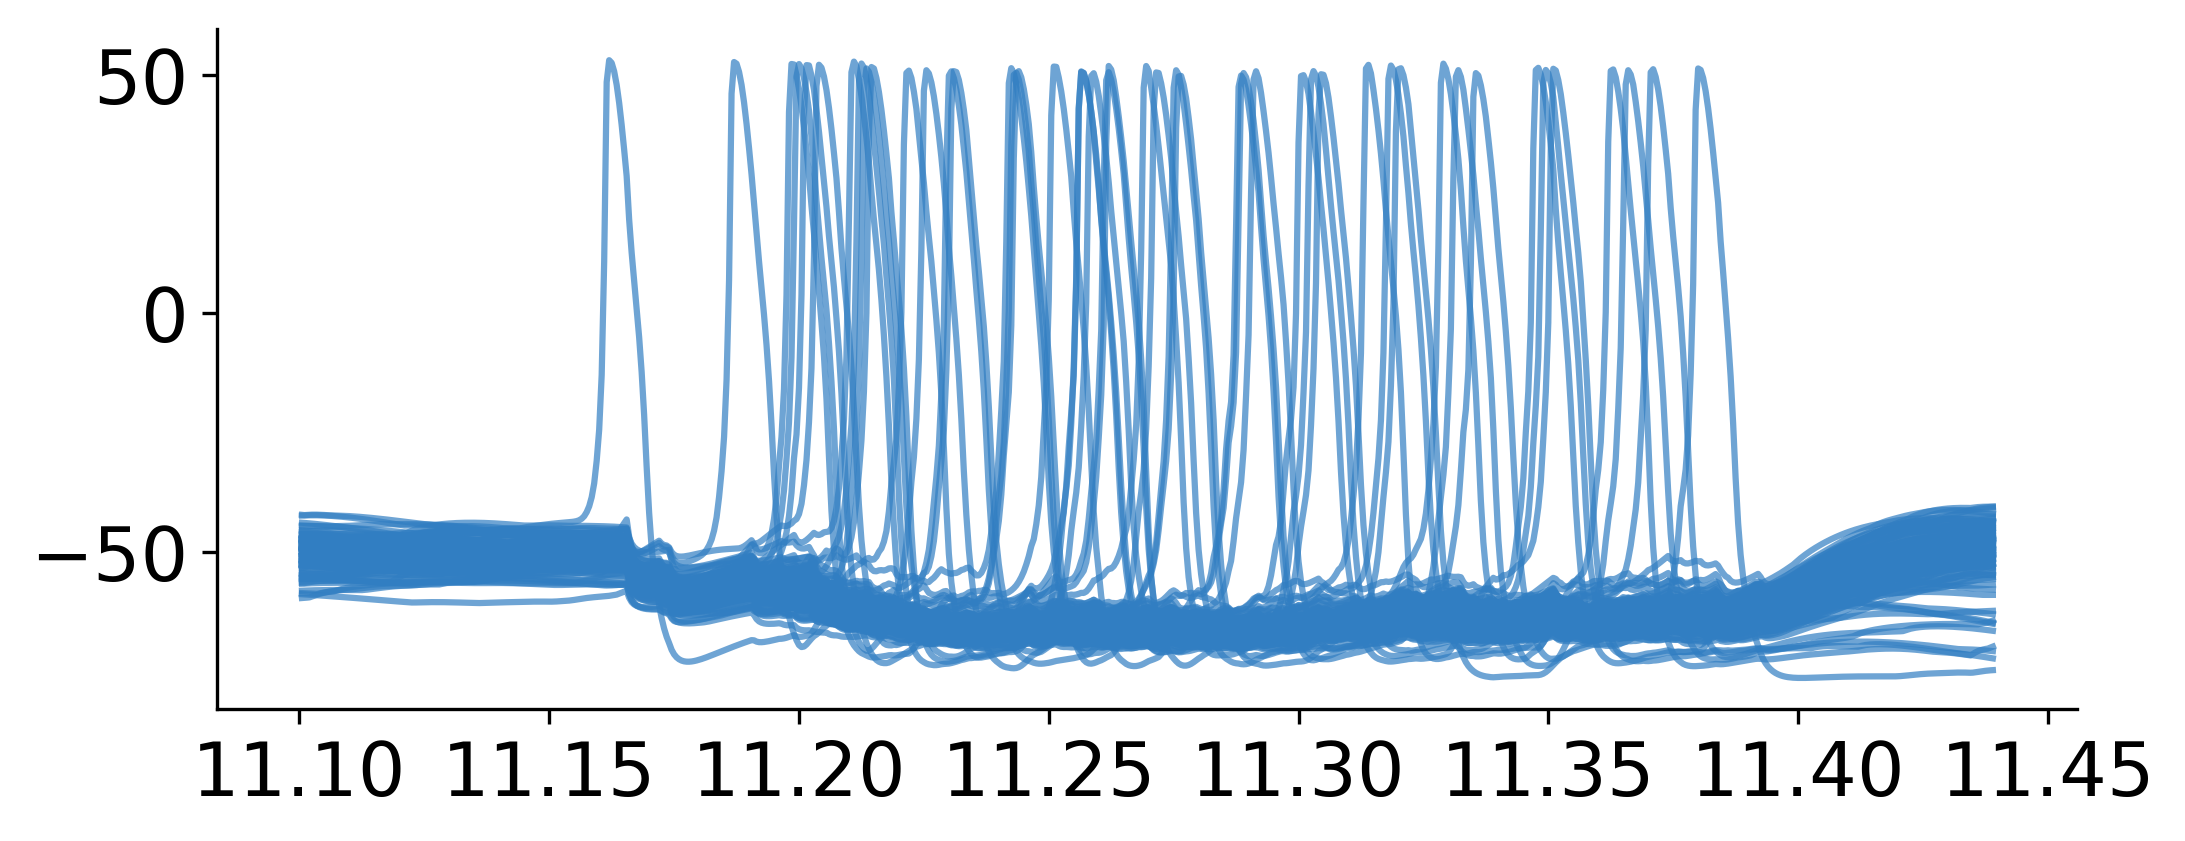

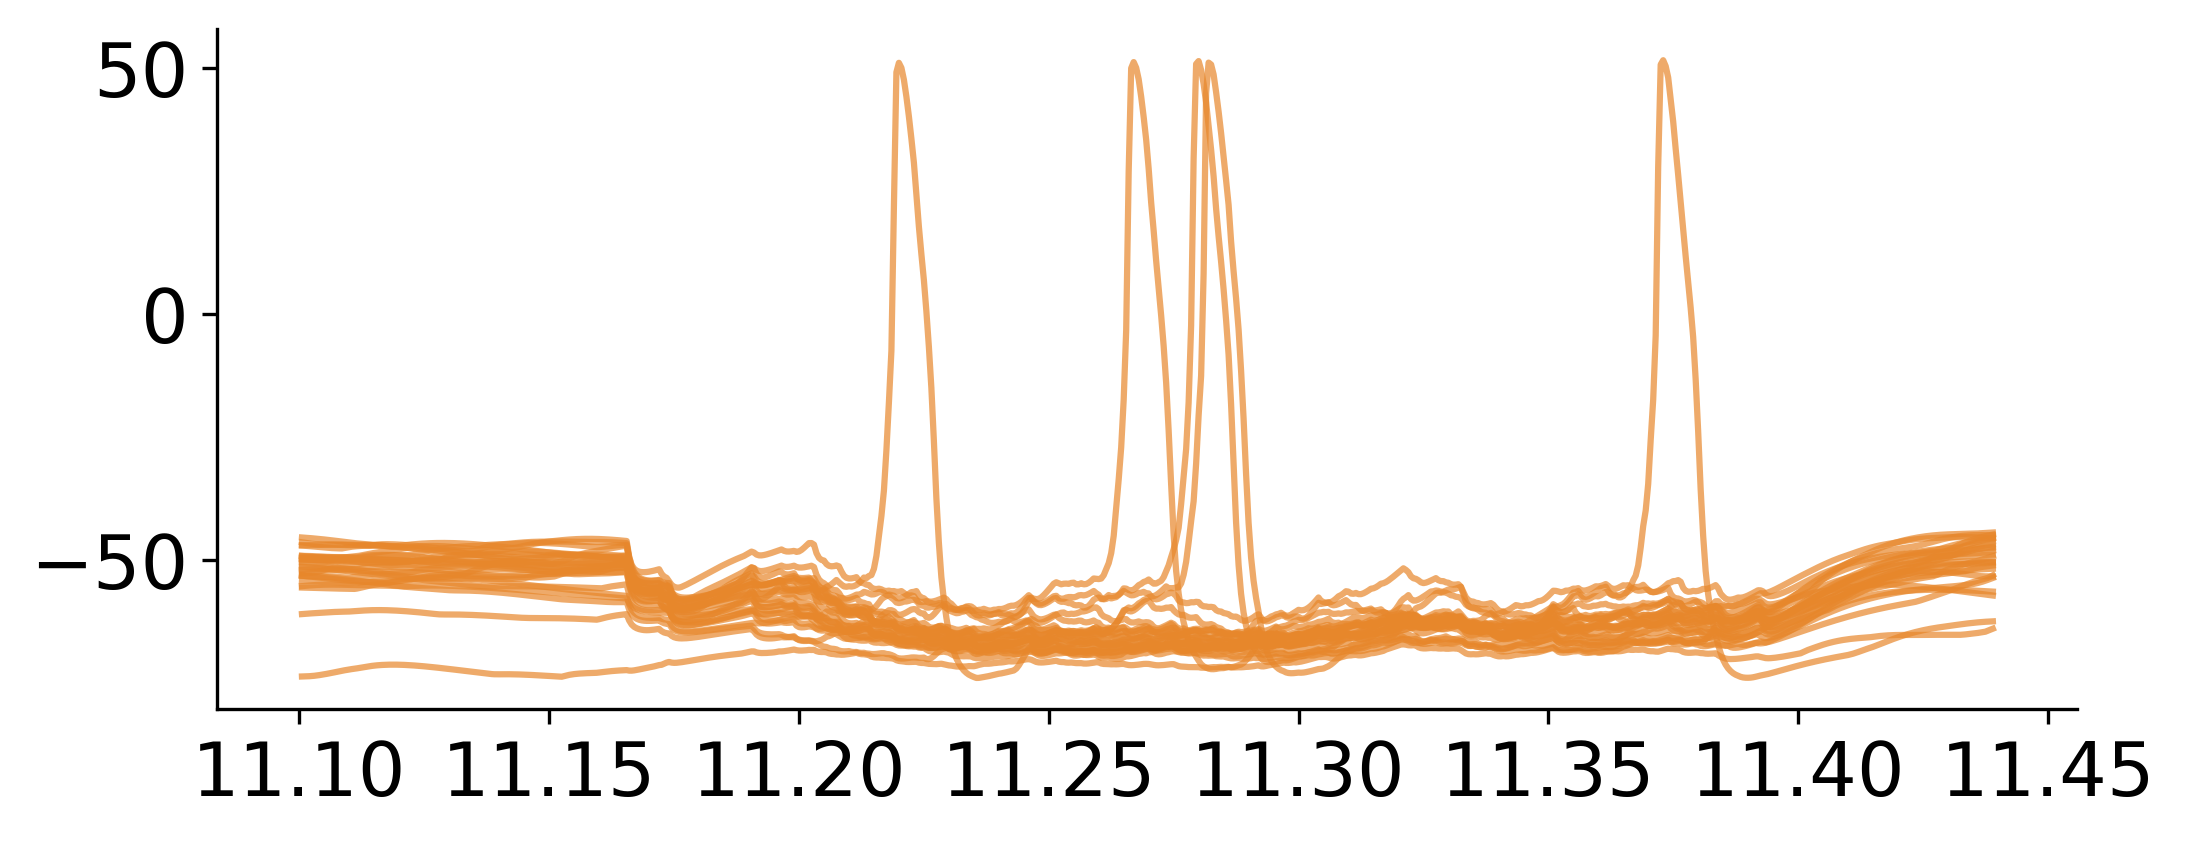

In [271]:
from analysis_utils import butter_bandpass_filter
from scipy.signal import welch, spectrogram

t_vec = np.asarray(t_vec)
s = np.where(t_vec > 10600+500)[0][0]
e = np.where(t_vec < 10940+500)[0][-1]


fig = plt.figure(dpi=300,figsize=(8,3))
ax  = fig.gca()
plt.plot(np.divide(t_vec[s:e], 1000.), np.asarray(exc_v_vecs).T[s:e, diagram.place_information[0]['place']],
         color=(49/255.,126/255.,194/255.), alpha=0.7)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
fig = plt.figure(dpi=300,figsize=(8,3))
ax  = fig.gca()
plt.plot(np.divide(t_vec[s:e], 1000.), np.asarray(exc_v_vecs).T[s:e, diagram.place_information[0]['not place']], 
         color=(231/255.,135/255.,43/255.), alpha=0.7)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

/mnt/d/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


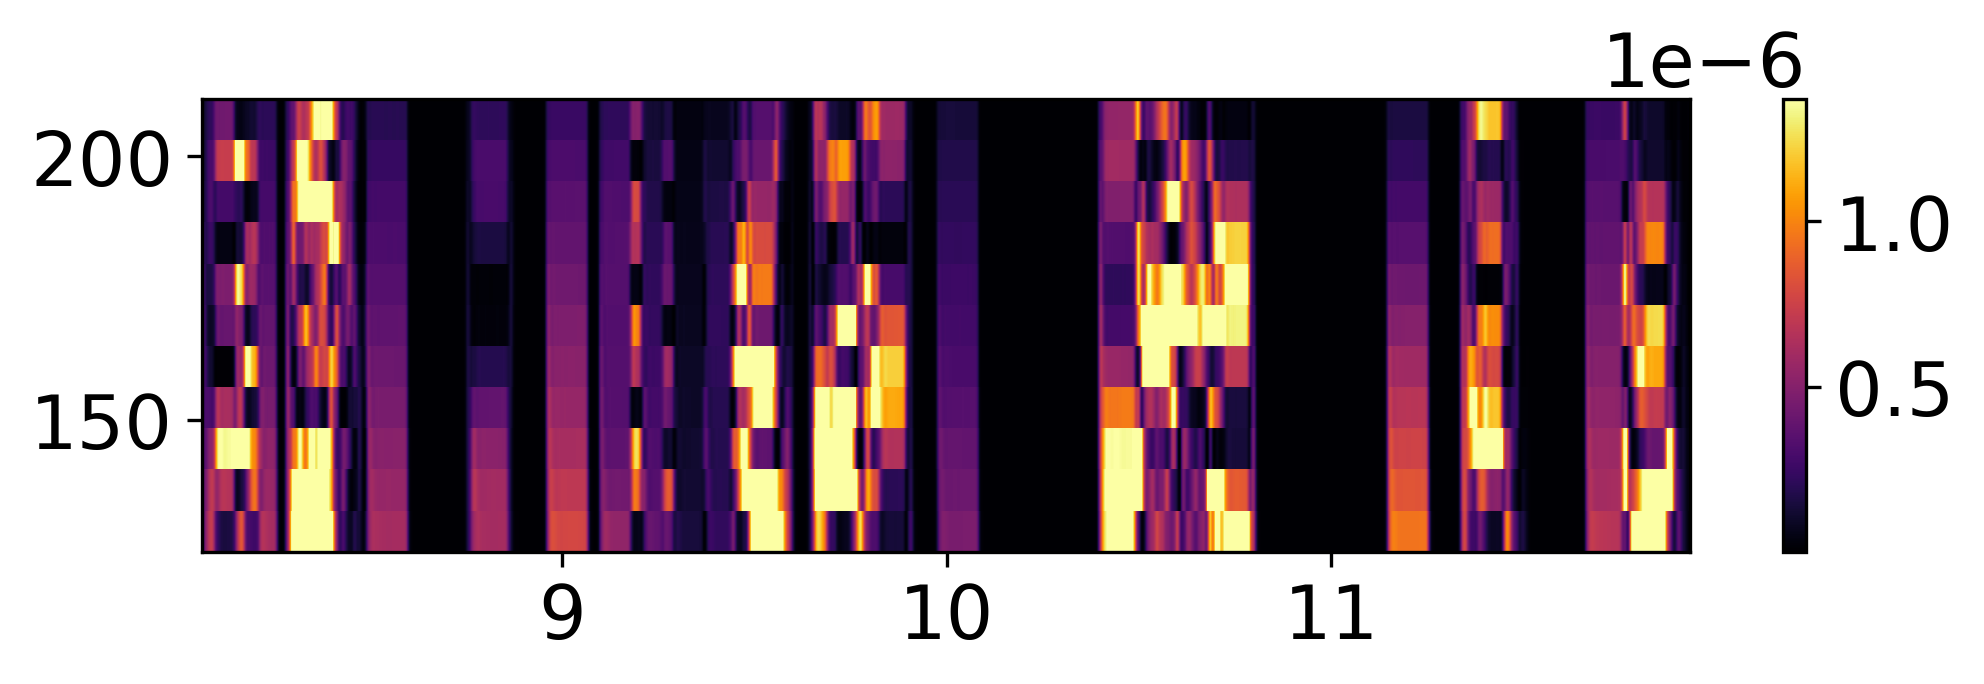

In [151]:

lfp = circuit.lfp
lfp_np = np.asarray([np.asarray(l, dtype='float32') for l in lfp], dtype='float32')
lfp_mean = lfp_np.mean(axis=0)
lfp_filtered = butter_bandpass_filter(lfp_mean, 100.0, 220.0, 2000., order=3)



start = np.where(np.asarray(t_vec) > 8000+500)[0][0]
end   = np.where(np.asarray(t_vec) < 12000+500)[0][-1]

ns = 256
lfp_f, lfp_t, lfp_S = spectrogram(lfp_filtered[start:end], fs=2000., nfft=ns, nperseg=ns, noverlap=ns-1)
lfp_t += 8.0
fs, fe = np.where(lfp_f >= 120.0)[0][0], np.where(lfp_f <= 220)[0][-1]
lfp_S_reduced = lfp_S[fs:fe,:]
minn = np.percentile(lfp_S_reduced, 5.)
maxx = np.percentile(lfp_S_reduced, 95.)

plt.figure(dpi=300, figsize=(8,2))
plt.pcolormesh(lfp_t, lfp_f[fs:fe], lfp_S_reduced, vmin=minn, vmax=maxx, cmap='inferno')
plt.colorbar()
#plt.xticks([])
plt.show()


398


(-19.85, 416.85, -0.05214949444992256, 0.051085510255522826)

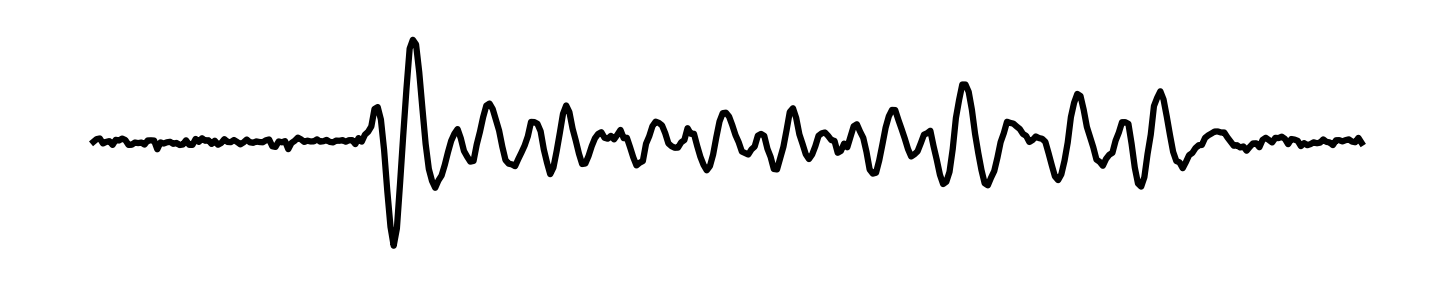

In [153]:

start = np.where(np.asarray(t_vec) > 10500+500)[0][0]
end   = np.where(np.asarray(t_vec) < 10700+500)[0][-1]
noise_add = np.random.normal(0,1.0e-3,size=end-start)
print(len(noise_add))
fig = plt.figure(figsize=(6,1.0), dpi=300)
ax  = fig.gca()
plt.plot(lfp_filtered[start:end] + noise_add, color='k')
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.axis('off')

9998


(-499.85, 10496.85, -0.05956965174547215, 0.0651948383287005)

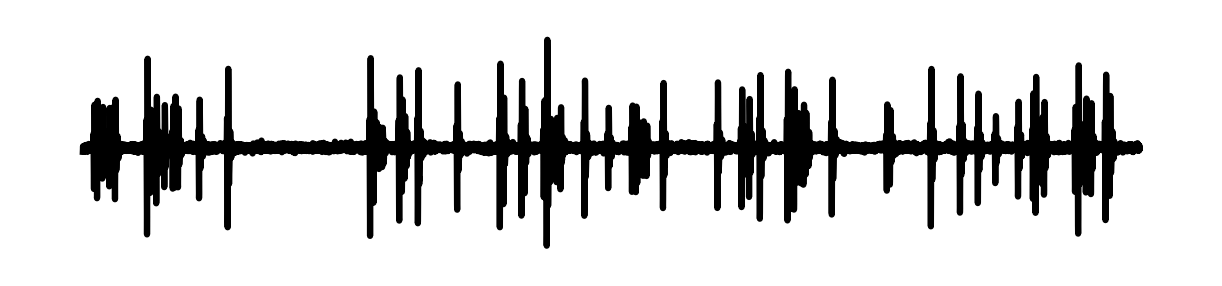

In [61]:

start = np.where(np.asarray(t_vec) > 5000+500)[0][0]
end   = np.where(np.asarray(t_vec) < 10000+500)[0][-1]
noise_add = np.random.normal(0,1.0e-3,size=end-start)
print(len(noise_add))
fig = plt.figure(figsize=(5,1.0), dpi=300)
ax  = fig.gca()
plt.plot(lfp_filtered[start:end] + noise_add, color='k')
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.axis('off')

place-cue corr (0.19675391120978336, 0.0011064957752705716)
place-pvbc corr (0.9237488909101236, 1.5250777451149507e-114)
pvbc-cue corr (0.4728457643456437, 1.4742745869351758e-16)


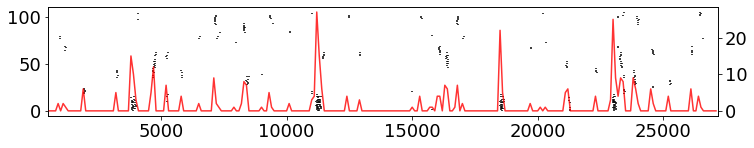

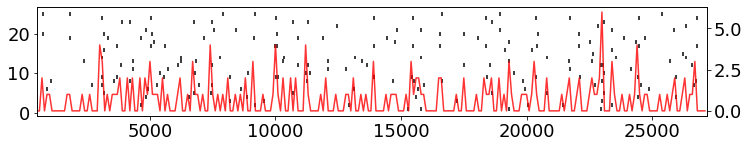

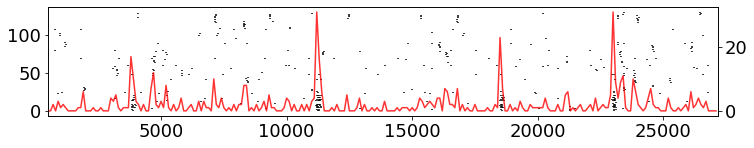

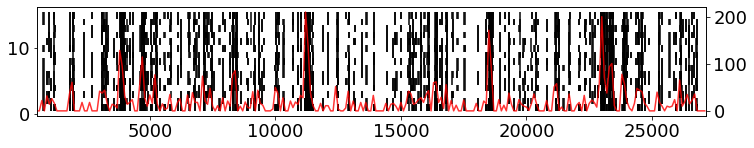

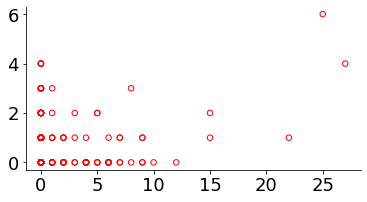

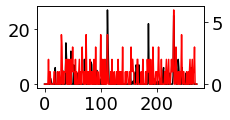

r,p -0.05963544852416568 0.32714738617908556


In [257]:
def plot_spikes(c, population_id, title, start, finish, gids=None, color='k'):
    spike_times = c.get_cell_spikes(population_id)
    if gids is not None:
        temp_spike_times = []
        for i in range(len(spike_times)):
            if i in gids:
                temp_spike_times.append(spike_times[i])
        spike_times = temp_spike_times
        
    frs = []
    fig, ax = plt.subplots(figsize=(12,2))
    for (i,sts) in enumerate(spike_times):
        sts = np.asarray(sts)
        ax.vlines(np.asarray(sts), i+0.5, i+1.5, color=color)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
    ax.set_xlim([start, finish])
    #ax.set_title('%s fr: %0.3f' % (title, np.mean(frs)))
    
    ax2 = ax.twinx()
    
    tick = 0
    jump = 100 #50ms hops
    nspikes = []
    while tick < finish:
        curr_nspikes = 0
        for (i,sts) in enumerate(spike_times):
            tick_end = tick + jump
            sts = np.asarray(sts)
            sts_chop = sts[np.where( (sts>=tick) & (sts<=tick_end)) [0]]
            curr_nspikes += len(sts_chop)
        tick += jump
        nspikes.append(curr_nspikes)
    ax2.plot([i*jump for i in range(len(nspikes))],nspikes, color='r', alpha=0.8)
    ax2.set_xlim([start, finish])
    return nspikes

start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 4 + 500

nspikes_place = plot_spikes(circuit, 0, 'PYR place', start, finish, diagram.place_information[0]['place'])
nspikes_cue   = plot_spikes(circuit, 0, 'PYR cue', start, finish, diagram.place_information[0]['not place'])
nspikes_total = plot_spikes(circuit, 0, 'PYR all', start, finish, np.arange(130))


nspikes_pvbc  = plot_spikes(circuit, 1, 'PVBC', start, finish)
# plot_spikes(c, 2, 'AAC', start, finish)
# plot_spikes(c, 3, 'BiS', start, finish)
# plot_spikes(c, 4, 'OLM', start, finish)
# plot_spikes(c, 5, 'ISCCR', start, finish)
#plot_spikes(6, 'ISCCK', start, finish)
from scipy.stats import pearsonr, spearmanr

print('place-cue corr', pearsonr(nspikes_place, nspikes_cue))
print('place-pvbc corr', pearsonr(nspikes_place, nspikes_pvbc))
print('pvbc-cue corr', pearsonr(nspikes_pvbc, nspikes_cue))

#(6,3)
fig = plt.figure(figsize=(6,3))
ax  = fig.gca()
plt.scatter(nspikes_place, nspikes_cue, facecolor='none', edgecolor='red',s=30)
# plt.xlabel('number place cells spikes')
# plt.ylabel('number cue cells spikes')
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show()

fig, ax = plt.subplots(figsize=(3,1.5))
ax.plot(nspikes_place, color='k')
ax2 = ax.twinx()
ax2.plot(nspikes_cue, color='r')
plt.show()

from scipy.stats import pearsonr, spearmanr
r, p = spearmanr(nspikes_place, nspikes_cue)
print('r,p', r, p)

272
(160, 2)


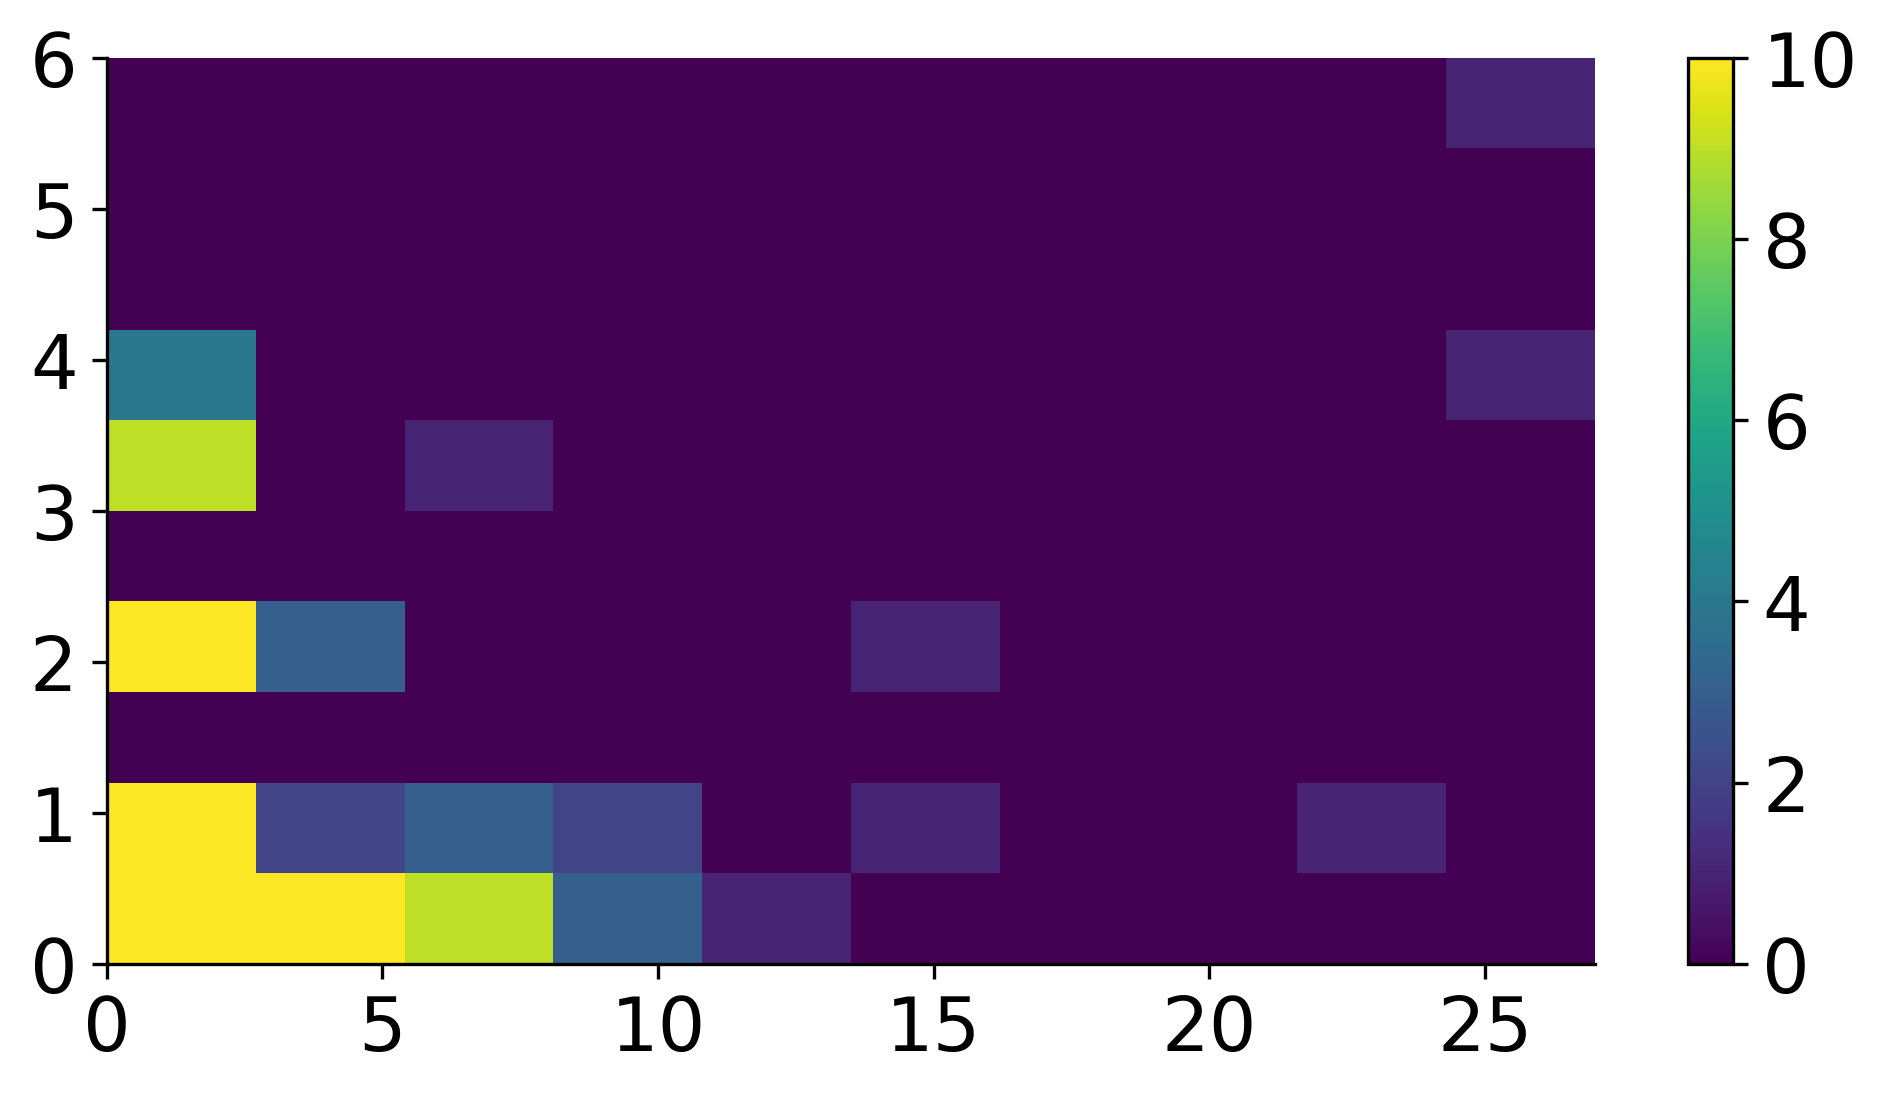

In [262]:
import seaborn as sns
import pandas as pd

#sns.kdeplot(data = df, x="x", y="y", cmap="Reds", shade=True)
#df = pd.DataFrame({'cue': np.asarray(nspikes_cue), 'place': np.asarray(nspikes_place)})

print(len(nspikes_place))
nspikes_combined = list(zip(nspikes_place, nspikes_cue))
nspikes_combined_refined = []
for (a,b) in nspikes_combined:
    if (a == 0 and b == 0): continue
    nspikes_combined_refined.append([a,b])
nspikes_combined_refined = np.asarray(nspikes_combined_refined)
print(nspikes_combined_refined.shape)

fig = plt.figure(figsize=(8,4), dpi=300)
ax  = fig.gca()
plt.hist2d(nspikes_combined_refined[:,0], nspikes_combined_refined[:,1], vmin=0, vmax=10)
plt.colorbar()
#plt.scatter(nspikes_place, nspikes_cue, facecolor='none', edgecolor='gray',s=10)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show()





# print(len(nspikes_place))
# max_place = max(nspikes_place)
# max_cue   = max(nspikes_cue)
# heatmap_matrix = np.zeros((max_place+1, max_cue+1))
# for (a,b) in list(zip(nspikes_place, nspikes_cue)):
#     if a == 0 and b == 0: continue
#     if heatmap_matrix[a,b] >= 10: continue
#     heatmap_matrix[a,b] += 1
    
# from copy import deepcopy
# cleaned_matrix = deepcopy(heatmap_matrix)
# cleaned_matrix[heatmap_matrix==0] = None
    
# fig = plt.figure(dpi=300, figsize=(14,3.0))
# plt.imshow(cleaned_matrix.T, aspect='auto', extent=(0,max_place+1,0,max_cue+1))
# plt.colorbar()
# # plt.xlabel('number place cells spikes')
# # plt.ylabel('number cue cells spikes')
# plt.show()


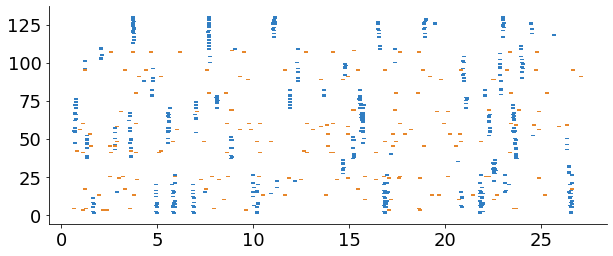

In [64]:
def plot_spikes(c, population_id, title, start, finish, gids=None, **kwargs):
    spike_times = c.get_cell_spikes(population_id)
    if gids is not None:
        temp_spike_times = []
        for i in range(len(spike_times)):
            if i in gids:
                temp_spike_times.append(np.divide(spike_times[i], 1000.))
        spike_times = temp_spike_times
        
    frs = []
    fig, ax = plt.subplots(figsize=(10,4))
    for (i,sts) in enumerate(spike_times):
        sts = np.asarray(sts)
        if i in kwargs['place ids']:
            color = kwargs['place colors']
        else:
            color = kwargs['cue colors']
        ax.vlines(np.asarray(sts), i+0.5, i+1.5, color=color, linewidth=4)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
    #ax.set_xlim([start/1000., finish/1000.])
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0.0)  

place_ids = diagram.place_information[0]['place']
place_colors = (49/255., 126/255., 194/255.)
cue_ids = diagram.place_information[0]['not place']
cue_colors = (231/255., 135/255., 43/255.)

kwargs = {'place ids': place_ids, 'place colors': place_colors, 'cue ids': cue_ids, 'cue colors': cue_colors} 
start = 18000
finish = 24000
plot_spikes(circuit, 0, 'PYR all', start, finish, np.arange(130), **kwargs)


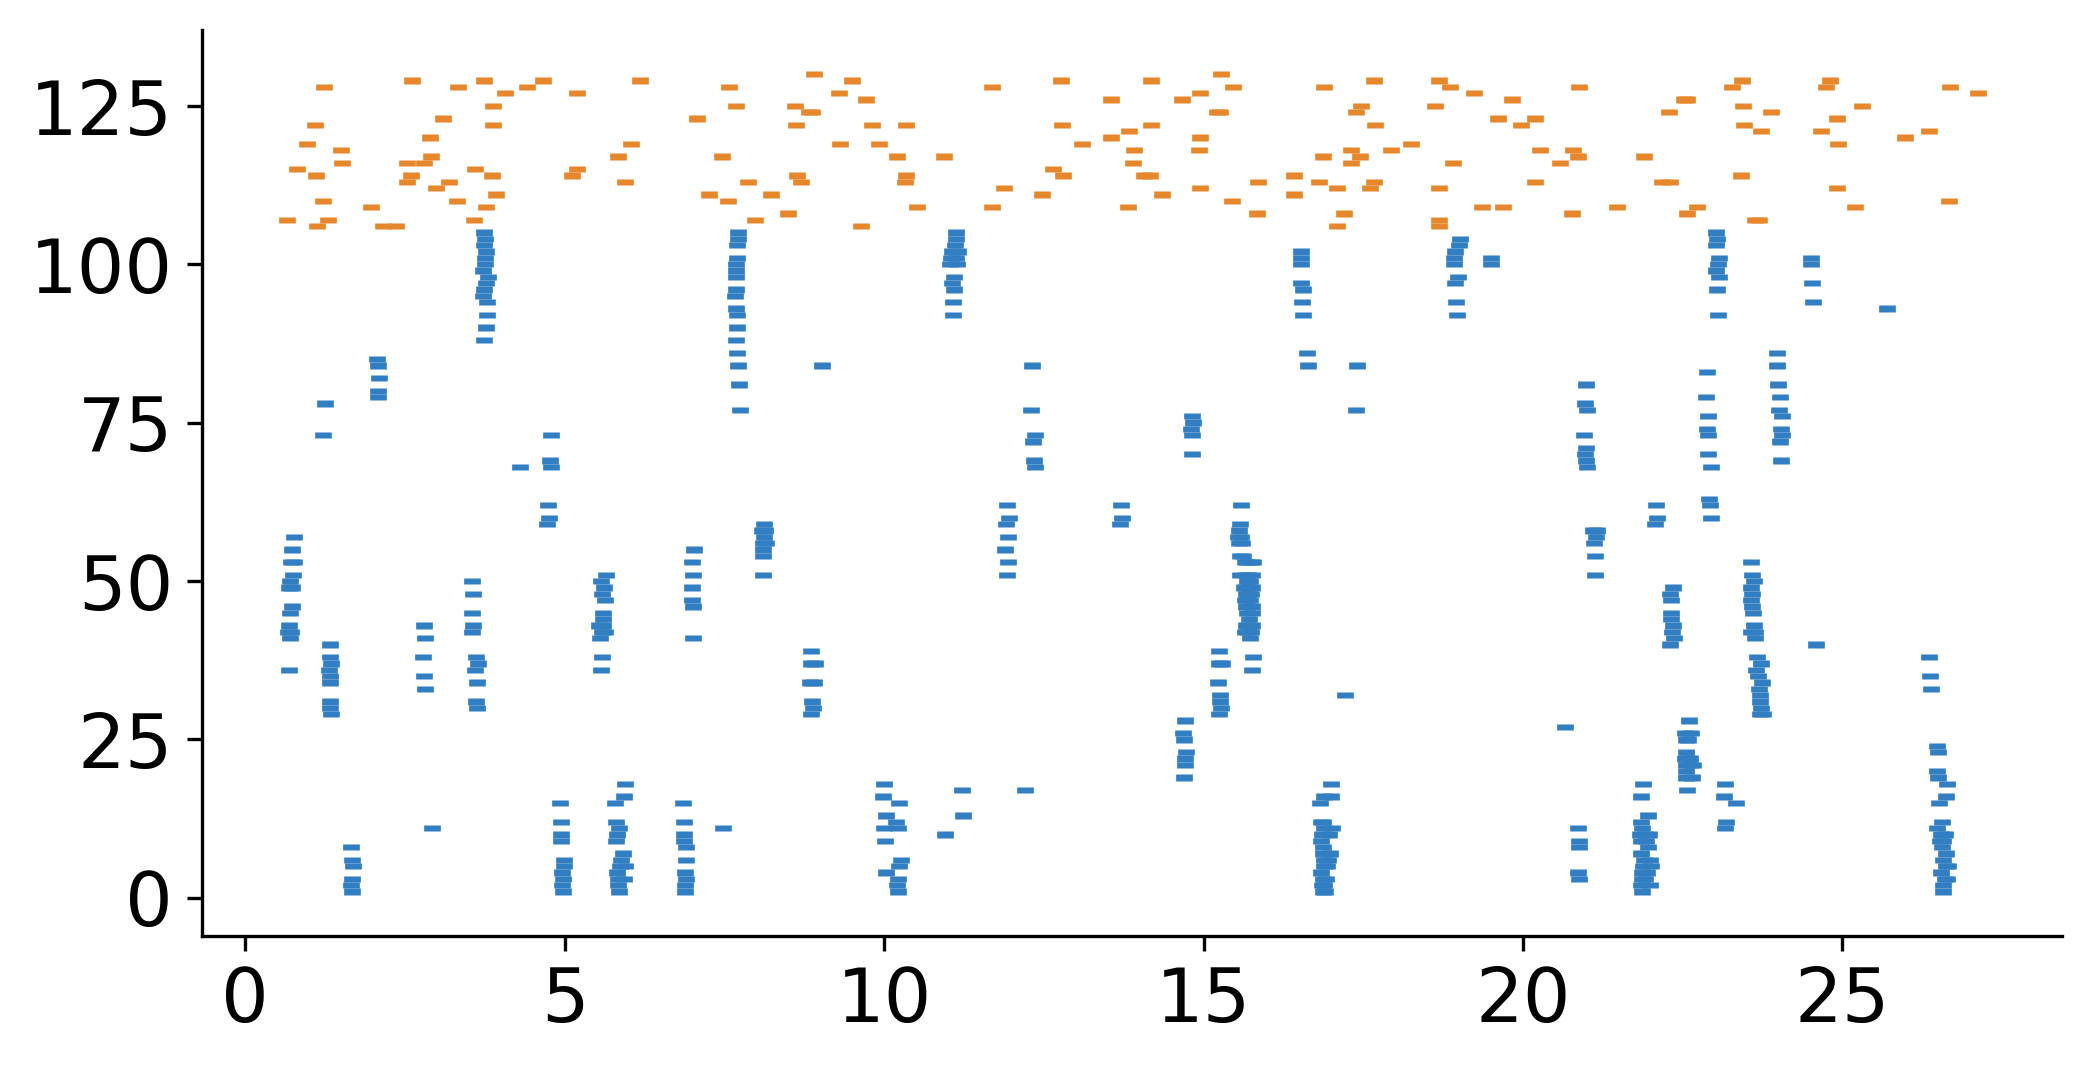

In [148]:
def plot_spikes(c, population_id, title, start, finish, gids=None, **kwargs):
    place_ids = kwargs['place ids']
    cue_ids   = kwargs['cue ids']
    
    spike_times = c.get_cell_spikes(population_id)
    if gids is not None:
        temp_spike_times = []
        for i in range(len(spike_times)):
            if i in gids:
                temp_spike_times.append(np.divide(spike_times[i], 1000.))
        spike_times = temp_spike_times
        
    frs = []
    fig, ax = plt.subplots(dpi=300, figsize=(8,4))
    count = 0
    for (i,pid) in enumerate(place_ids):
        sts = np.asarray(spike_times[pid])
        ax.vlines(np.asarray(sts), i+0.5, i+1.5, color=kwargs['place colors'], linewidth=4)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
        count += 1
    for (i,cid) in enumerate(cue_ids):
        sts = np.asarray(spike_times[cid])
        ax.vlines(np.asarray(sts), i+count+0.5, i+count+1.5, color=kwargs['cue colors'], linewidth=4)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)     
        
    
    #ax.set_xlim([start/1000., finish/1000.])
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0.0)  

place_ids = diagram.place_information[0]['place']
place_colors = (49/255., 126/255., 194/255.)
cue_ids = diagram.place_information[0]['not place']
cue_colors = (231/255., 135/255., 43/255.)

kwargs = {'place ids': place_ids, 'place colors': place_colors, 'cue ids': cue_ids, 'cue colors': cue_colors} 
start = 10000
finish = 24000
plot_spikes(circuit, 0, 'PYR all', start, finish, np.arange(130), **kwargs)


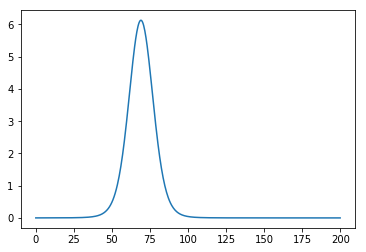

[]

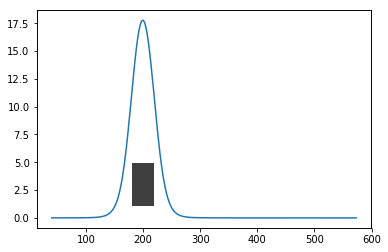

In [137]:
all_exc_frs = []
all_exc_spikes = []
valid_gids = []
start_time = time_for_single_lap * 0 + 500
end_time   = time_for_single_lap * 1 + 500

for i in circuit.neurons[0].keys():
    exc_spikes = np.asarray(circuit.neurons[0][i].spike_times)

    time_idxs = np.where( (exc_spikes >= start_time) & (exc_spikes <= end_time))[0]
    exc_spikes = exc_spikes[time_idxs]
    all_exc_spikes.append(exc_spikes)
    step = 12.5 # ms
    estimated_times = np.arange(start_time, end_time, step=step)

    try:
        estimated_fr,_ = baks(exc_spikes/1000., estimated_times/1000., a=10.0) # 1.75?
        all_exc_frs.append(estimated_fr)
        valid_gids.append(i)
    except:
        continue
all_exc_frs = np.asarray(all_exc_frs, dtype='float32')

idx = 30
plt.figure()
plt.plot(estimated_times/1000*30. - start_time/1000*30, all_exc_frs[valid_gids[idx]])
plt.show()

fig, ax = plt.subplots()
ax.plot(estimated_times/step, all_exc_frs[idx])
ax2 = ax.twinx()
ax2.vlines(all_exc_spikes[valid_gids[idx]]/step, 0.5, 1.5)
ax2.set_ylim([0, 5])
ax2.set_yticks([])


[0, 1, 2, 4, 5, 6, 9, 10, 11, 12, 14, 15, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 31, 32, 34, 36, 38, 39, 40, 42, 43, 45, 48, 49, 50, 51, 52, 53, 55, 57, 58, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 83, 85, 86, 87, 89, 91, 92, 93, 94, 95, 97, 98, 101, 104, 105, 106, 107, 110]


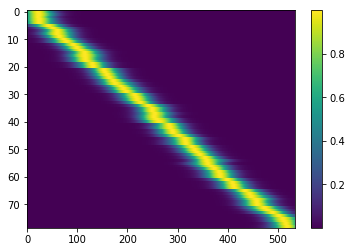

{0, 1}


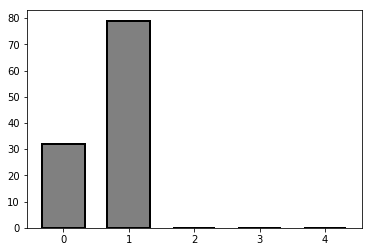

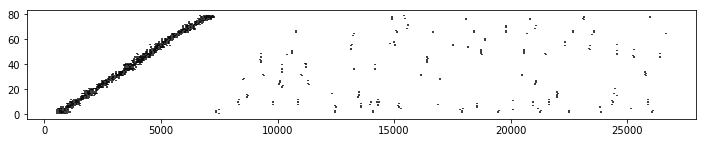

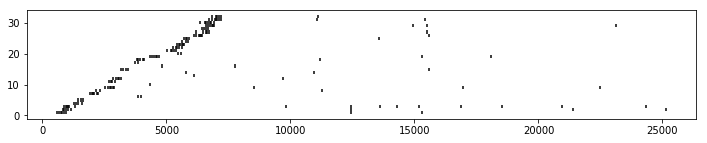

In [139]:


valid_idxs = []
invalid_idxs = []
for i in range(len(all_exc_frs)):
    sl = all_exc_frs[i]
    if not np.all(sl < 10.0): valid_idxs.append(i)
    else: 
        invalid_idxs.append(i)
valid_exc_frs = all_exc_frs[valid_idxs,:] # flip a rooni
print(valid_idxs)

normed = []
for i in range(len(valid_exc_frs)):
    normed.append(valid_exc_frs[i] / valid_exc_frs[i].max())
normed = np.asarray(normed, dtype='float32')

whereismax = []
for i in range(len(normed)):
    sl = normed[i,:]
    whereismax.append(sl.argmax())
sorted_max = np.argsort(whereismax)

normed_sorted        = normed[sorted_max,:]
valid_exc_frs_sorted = valid_exc_frs[sorted_max,:]


plt.figure()
plt.imshow(normed_sorted, cmap='viridis', aspect='auto')
plt.colorbar()
plt.show()



# fig, ax = plt.subplots(5, 5, figsize=(12,8))
# for i in range(25):
#     xx = int(i/5)
#     yy = int(i%5)
#     ax[xx,yy].plot(estimated_times, normed_sorted[i])
#     ax[xx,yy].hlines(0.80, estimated_times[0], estimated_times[-1], linestyle='--')
#     ax[xx,yy].set_title(i)
    
ncrossed = []
for i in range(len(valid_exc_frs_sorted)):
    sl = normed_sorted[i]
    crossed = False
    ticks = 0
    for s in sl:
        if s > 0.80 and not crossed: 
            crossed = True
            ticks += 1
        if s <= 0.80 and crossed:
            crossed = False
    ncrossed.append(ticks)

ncrossed = np.asarray(ncrossed + [0 for _ in range(len(all_exc_frs) - len(valid_exc_frs))])
print(set(ncrossed))
plt.figure()
plt.hist(ncrossed, bins=[0,1,2,3,4,5], align='left', rwidth=0.65, 
         edgecolor='k', color='gray', linewidth=2)
plt.show()

spike_times = np.asarray(circuit.get_cell_spikes(0))[valid_gids]
valid_raster = []
for nid in np.asarray(valid_idxs)[sorted_max]:
    valid_raster.append(spike_times[nid])

plt.figure(figsize=(12,2))
for (i,sts) in enumerate(valid_raster):
    sts = np.asarray(sts)
    plt.vlines(np.asarray(sts), i+0.5, i+1.5)
#plt.xlim([start_time, end_time])
#plt.xlim([end_time, end_time+time_for_single_lap])
plt.show()


invalid_raster = []
for nid in invalid_idxs:
    invalid_raster.append(spike_times[nid])

plt.figure(figsize=(12,2))
for (i,sts) in enumerate(invalid_raster):
    sts = np.asarray(sts)
    plt.vlines(np.asarray(sts), i+0.5, i+1.5)
#plt.xlim([start_time, end_time])
#plt.xlim([end_time, end_time+time_for_single_lap])
plt.show()


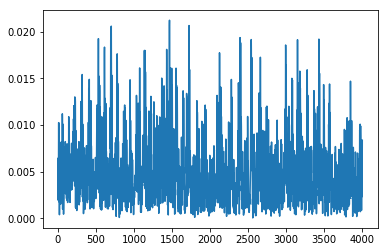

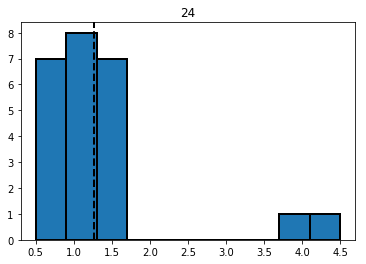

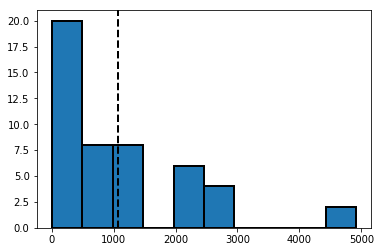

In [130]:
from scipy.signal import hilbert

lfp_analytic = hilbert(lfp_filtered)
lfp_envelope = np.abs(lfp_analytic)
plt.figure()
plt.plot(lfp_envelope[2000:6000])

mean_filt = lfp_envelope.mean()
std_filt  = lfp_envelope.std()
cutoff = mean_filt + 5.0*std_filt

ripple_start, ripple_end = [], []
intra_ripple_duration = []
in_ripple = 0

for i in range(len(lfp_envelope)):
        val = lfp_envelope[i]
        if in_ripple:
            if val < cutoff:
                ripple_end.append(i)
                in_ripple = 0
        else:
            if val >= cutoff:
                ripple_start.append(i)
                in_ripple = 1
                if len(ripple_end) > 0:
                    intra_rip_dur = (i-ripple_end[-1])*0.5
                    intra_ripple_duration.append(intra_rip_dur)
                    if intra_rip_dur < 10.0:
                        ripple_start = ripple_start[:-1]
                        ripple_end   = ripple_end[:-1]
                    else: intra_ripple_duration.append(intra_rip_dur)

 
durations = []
for rs, re in list(zip(ripple_start, ripple_end)):
    durations.append( (re-rs)*0.5)
plt.figure()
plt.hist(durations, bins=10, edgecolor='k', linewidth=2)
plt.axvline(np.mean(durations), linestyle='--', color='k', linewidth=2)
plt.title(len(durations))
plt.show()

plt.figure()
plt.hist(intra_ripple_duration, bins=10, edgecolor='k', linewidth=2)
plt.axvline(np.mean(intra_ripple_duration), linestyle='--', color='k', linewidth=2)
plt.show()

